In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from common.optimizer import SGD
from hidden_others.dataset import ptb

In [2]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grad = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None


    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - df_next**2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T ,dt)
        dx = np.dot(dt, Wx.T)

        self.grad[0][...] = dWx
        self.grad[1][...] = dWh
        self.grad[2][...] = db

        return dx, dh_prev

In [31]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grad =[np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape # N:バッチ数, T:時系列データ数, D:次元数
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T): # バッチのt時間を対象にする
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h) # prev_h -> next_hへ
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs


    def backward(self, dhs):
        Ws, Wh, b = self.params.shape
        N, T, D = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reverse(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh # self.dhはseq2seqで使用

        return dxs

In [32]:
a = np.array([[0, 0], [1, 1]])
idx = np.array([0, 1, 0, 0])

a[idx]

array([[0, 0],
       [1, 1],
       [0, 0],
       [0, 0]])

In [33]:
a[:, 1]

array([0, 1])

In [34]:
a[np.arange(2), [0, 1]]

array([0, 1])

In [30]:
a

array([[0, 0],
       [1, 1]])

In [9]:
# RNNLM

from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        
        # レイヤーの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wh, rnn_Wx, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]

        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]


        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads


    # 順伝播
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss


    # バックプロパゲーション
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        return dout

    # Time_RNNのhの保持を止める
    def reset_state(self):
        self.rnn_layer.reset_state()

    

In [41]:
# hyperparams
batch_size = 10
wordvec_size = 100
hidden_size = 100 # hの要素数
time_size = 5 # truncated BPTTの時間サイズ
lr = 0.1
max_epoch = 100

# 学習データ
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)


xs = corpus[1:]
ts = corpus[:-1]
data_size = len(xs)

print(f"corpus size:{corpus_size}, vocabulary size: {vocab_size}")


# 学習時の変数
max_iters = data_size // (batch_size * time_size) # 何回iterを回したらdatasetに達するのか, batch_size*time_sizeでtime_RNNの１ブロックを示している 
time_idx = 0
total_loss = 0
loss_count = 0

ppl_list = []


# モデル
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 各ミニバッチの各サンプルの読み込み開始地点
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチ
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size] # batchの各バッチのt0からt9の列を順々に埋めていっている
                batch_t[i, t] = ts[(offset + time_idx) % data_size] # time_idxをiter間で保持することで次のブロックの開始位置を取得する
            time_idx += 1 # 1 全datasizeを超えるとdata_sizeで割れて0からのデータ取得になる　

        # 勾配計算＝＞更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとのperplexity
    ppl = np.exp(total_loss / loss_count)
    print(f"| epoxh {epoch} | perplexity { ppl :.2f}")
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

corpus size:1000, vocabulary size: 418
| epoxh 0 | perplexity 343.26
| epoxh 1 | perplexity 236.77
| epoxh 2 | perplexity 213.48
| epoxh 3 | perplexity 207.78
| epoxh 4 | perplexity 199.09
| epoxh 5 | perplexity 192.96
| epoxh 6 | perplexity 178.93
| epoxh 7 | perplexity 173.76
| epoxh 8 | perplexity 161.14
| epoxh 9 | perplexity 147.17
| epoxh 10 | perplexity 134.32
| epoxh 11 | perplexity 120.88
| epoxh 12 | perplexity 108.37
| epoxh 13 | perplexity 103.23
| epoxh 14 | perplexity 91.28
| epoxh 15 | perplexity 84.49
| epoxh 16 | perplexity 76.81
| epoxh 17 | perplexity 70.00
| epoxh 18 | perplexity 66.20
| epoxh 19 | perplexity 63.85
| epoxh 20 | perplexity 58.59
| epoxh 21 | perplexity 53.05
| epoxh 22 | perplexity 50.13
| epoxh 23 | perplexity 47.48
| epoxh 24 | perplexity 43.42
| epoxh 25 | perplexity 41.61
| epoxh 26 | perplexity 37.84
| epoxh 27 | perplexity 35.94
| epoxh 28 | perplexity 33.43
| epoxh 29 | perplexity 31.36
| epoxh 30 | perplexity 29.20
| epoxh 31 | perplexity 28.

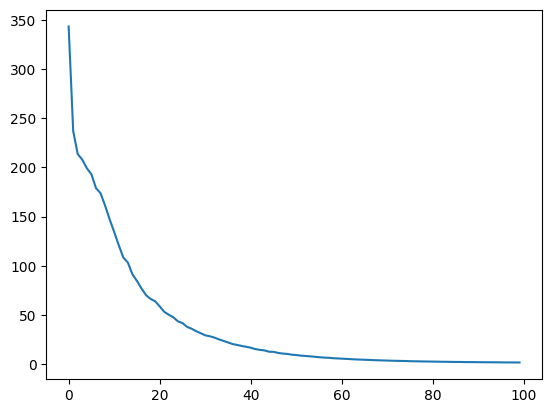

In [50]:
plt.plot(np.arange(len(ppl_list)), ppl_list)